In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.8 MB/s eta 0:00:00


In [4]:
# for data load
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import pandas as pd
from glob import glob
import segmentation_models as sm
import tensorflow as tf


# for reading and processing images
import imageio
from PIL import Image

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

# for bulding and running deep learning model
from sklearn.metrics import precision_score, recall_score, jaccard_score
from scipy.spatial.distance import directed_hausdorff
from sklearn.model_selection import train_test_split
from google.colab import files



Segmentation Models: using `tf.keras` framework.


In [5]:
tf.keras.backend.set_image_data_format('channels_last')

In [6]:
BACKBONE = 'resnet34'  # You can change this to 'efficientnetb0', 'seresnet50', etc.
preprocess_input = sm.get_preprocessing(BACKBONE)

# Define model
model = sm.Unet(backbone_name=BACKBONE, encoder_weights='imagenet', classes=1, activation='sigmoid')

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=sm.losses.DiceLoss(), metrics=['accuracy'])


85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [7]:
#upload kaggle token and download dataset
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip lgg-mri-segmentation.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: /content/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: /conte

In [8]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively

    """
    # Read the images folder like a list

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for file in path1:
        orig_img.append(file)
    for file in path2:
        mask_img.append(file)

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()

    return orig_img, mask_img



In [9]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask

    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.float32)
    i = 0
    # Resize images and masks
    for file in img:
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1[i], file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c))
        single_img = single_img/255.
        X[index] = single_img

        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2[i], single_mask_ind)
        single_mask = Image.open(path)
        single_mask = single_mask.resize((m_h, m_w))
        single_mask = np.array(single_mask,dtype=np.float32)
        # Ensure classes start from 0 (if necessary)
        single_mask[single_mask == 255] = 1  # Convert 255 to background (0)
        single_mask[single_mask > 1] = 1  # Ensure only two classes: 0 (background) and 1 (tumor)

        # Reshape and store in y
        single_mask = np.reshape(single_mask, (m_h, m_w, m_c))
        y[index] = single_mask
        i += 1
    return X, y



In [10]:
def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-7) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1e-7)

# IoU (Jaccard Index)
def iou(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

In [11]:
import numpy as np

def compute_metrics(y_true, y_pred):
    y_pred_bin = (y_pred > 0.5).astype(np.uint8)  # Convert to binary mask

    dice = dice_coefficient(y_true, y_pred_bin).numpy()
    iou_score = iou(y_true, y_pred_bin).numpy()

    precision = precision_score(y_true.flatten(), y_pred_bin.flatten(), zero_division=1)
    recall = recall_score(y_true.flatten(), y_pred_bin.flatten(), zero_division=1)

    hausdorff_dist = directed_hausdorff(y_true.squeeze(), y_pred_bin.squeeze())[0]

    return {
        'Dice Coefficient': dice,
        'IoU': iou_score,
        'Precision': precision,
        'Recall': recall,
        'Hausdorff Distance': hausdorff_dist
    }


In [12]:
def get_file_row(path):
    """Produces ID of a patient, image and mask filenames from a particular path"""
    path_no_ext, ext = os.path.splitext(path)
    filename = os.path.basename(path)

    patient_id = '_'.join(filename.split('_')[:3]) # Patient ID in the csv file consists of 3 first filename segments

    return [patient_id, path, f'{path_no_ext}_mask{ext}']

files_dir = '/content/dataset/lgg-mri-segmentation/kaggle_3m'
file_paths = glob(f'{files_dir}/*/*[0-9].tif')
filenames_df = pd.DataFrame((get_file_row(filename) for filename in file_paths), columns=['Patient', 'image_filename', 'mask_filename'])

filenames_df


,Patient,image_filename,mask_filename
0,TCGA_DU_8167,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
1,TCGA_DU_8167,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
2,TCGA_DU_8167,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
3,TCGA_DU_8167,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
4,TCGA_DU_8167,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
...,...,...,...
3924,TCGA_FG_7643,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
3925,TCGA_FG_7643,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
3926,TCGA_FG_7643,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...
3927,TCGA_FG_7643,/content/dataset/lgg-mri-segmentation/kaggle_3...,/content/dataset/lgg-mri-segmentation/kaggle_3...


<ipython-input-13-72d3cb186c30>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(path1[i])
<ipython-input-13-72d3cb186c30>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_view = imageio.imread(path2[i])


(256, 256, 3)
(256, 256)


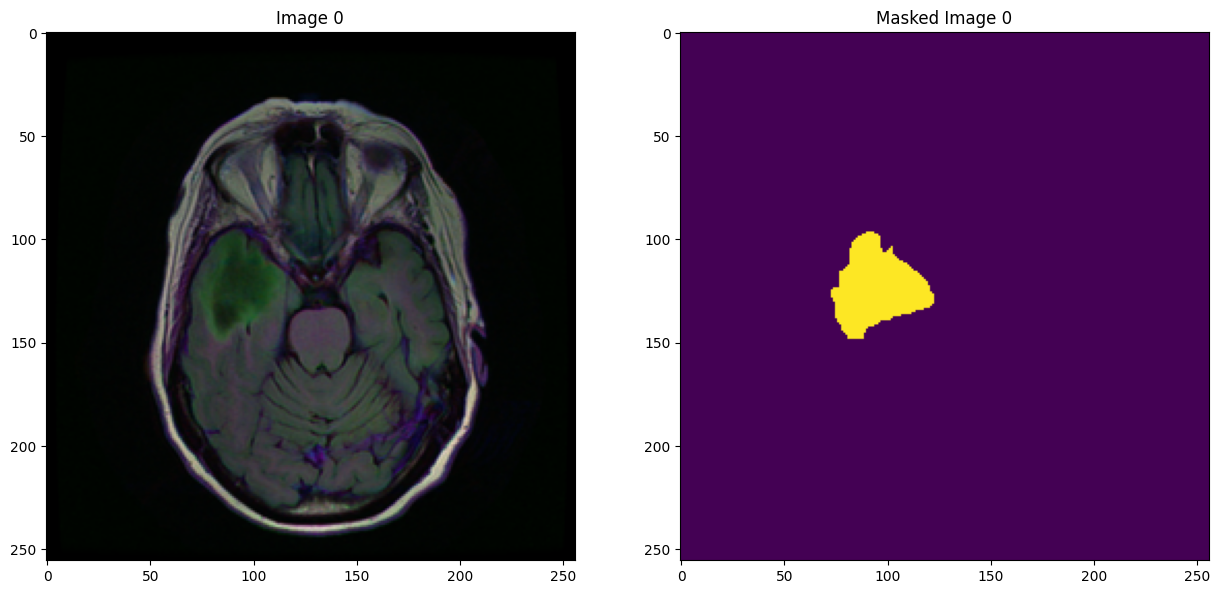

In [13]:
""" Load Train Set and view some examples """
# Call the apt function
path1 = filenames_df["image_filename"].tolist()
path2 = filenames_df["mask_filename"].tolist()
img, mask = LoadData (path1, path2)


# View an example of image and corresponding mask
show_images = 1
for i in range(show_images):
    img_view  = imageio.imread(path1[i])
    mask_view = imageio.imread(path2[i])
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

X Shape: (3929, 128, 128, 3)
Y shape: (3929, 128, 128, 1)
[0. 1.]


Text(0.5, 1.0, 'Processed Masked Image')

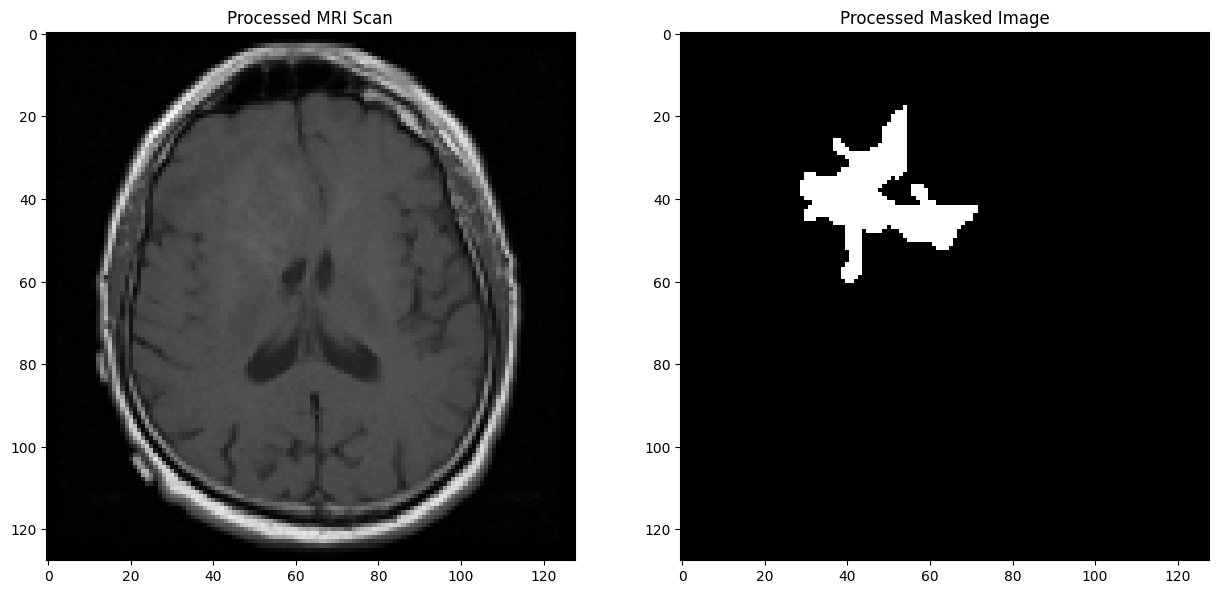

In [14]:
# Define the desired shape
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 2 classes : background, tumor
print(np.unique(y))

# Visualize the output
image_index = 5
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index, :, :, 0], cmap='gray')  # Show MRI image in grayscale
arr[0].set_title('Processed MRI Scan')

arr[1].imshow(y[image_index, :, :, 0], cmap='gray')  # Show mask in grayscale
arr[1].set_title('Processed Masked Image')


In [15]:
# Use scikit-learn's function to split the dataset
# Here, I have used 20% data as test/valid set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)



In [16]:
# Call the helper function for defining the layers for the model, given the input image size
model = sm.Unet(backbone_name='resnet34', encoder_weights='imagenet', classes=1, activation='sigmoid')

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=sm.losses.DiceLoss(),
              metrics=['accuracy', sm.metrics.IOUScore(), sm.metrics.FScore()])

In [33]:
# Run the model in a mini-batch fashion and compute the progress for each epoch
results = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_valid, y_valid))


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 311ms/step - accuracy: 0.9969 - f1-score: 0.8660 - iou_score: 0.7657 - loss: 0.1340 - val_accuracy: 0.9936 - val_f1-score: 0.7314 - val_iou_score: 0.5798 - val_loss: 0.2757
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - accuracy: 0.9974 - f1-score: 0.8859 - iou_score: 0.7972 - loss: 0.1142 - val_accuracy: 0.9936 - val_f1-score: 0.7358 - val_iou_score: 0.5850 - val_loss: 0.2706
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 262ms/step - accuracy: 0.9972 - f1-score: 0.8814 - iou_score: 0.7897 - loss: 0.1187 - val_accuracy: 0.9936 - val_f1-score: 0.7312 - val_iou_score: 0.5794 - val_loss: 0.2755
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 264ms/step - accuracy: 0.9972 - f1-score: 0.8759 - iou_score: 0.7831 - loss: 0.1241 - val_accuracy: 0.9936 - val_f1-score: 0.7306 - val_iou_score: 0.5787 - val_loss: 0.2754
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 278ms/step - accuracy: 0.9971 - f1-score: 0.8718 - iou_score: 0.7748 - loss: 0.1281 - val_accuracy

In [34]:
model.evaluate(X_valid, y_valid)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9935 - f1-score: 0.7068 - iou_score: 0.5601 - loss: 0.2934


[0.28302067518234253,
 0.9936397075653076,
 0.5734452605247498,
 0.7194374799728394]

In [29]:
# Results of Validation Dataset
def VisualizeResults(index):
    img = X_valid[index]
    img = img[np.newaxis, ...]
    pred_y = model.predict(img)
    pred_mask = (pred_y[0] > 0.5).astype(np.float32)  # Threshold at 0.5
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index, :, :, 0], cmap='gray')  # Display true mask
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:, :, 0], cmap='gray')  # Display thresholded prediction
    arr[2].set_title('Predicted Masked Image ')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


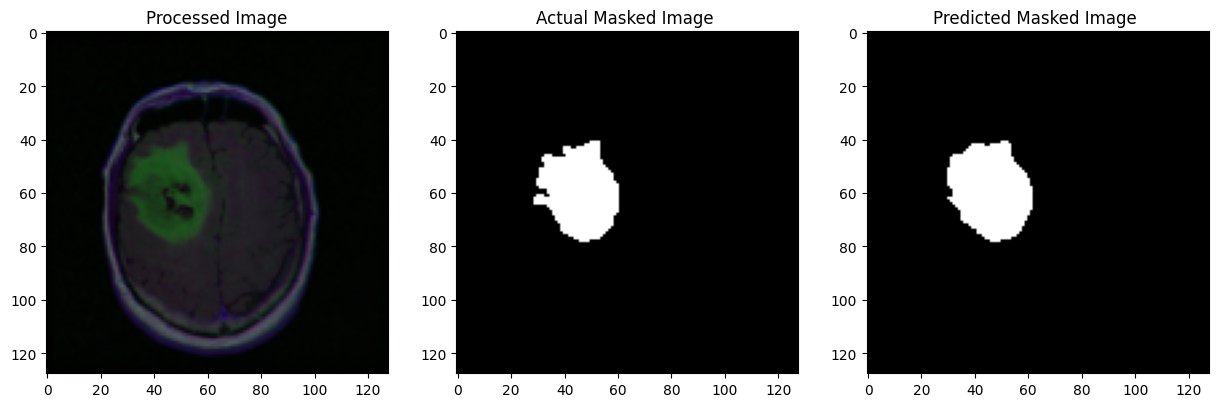

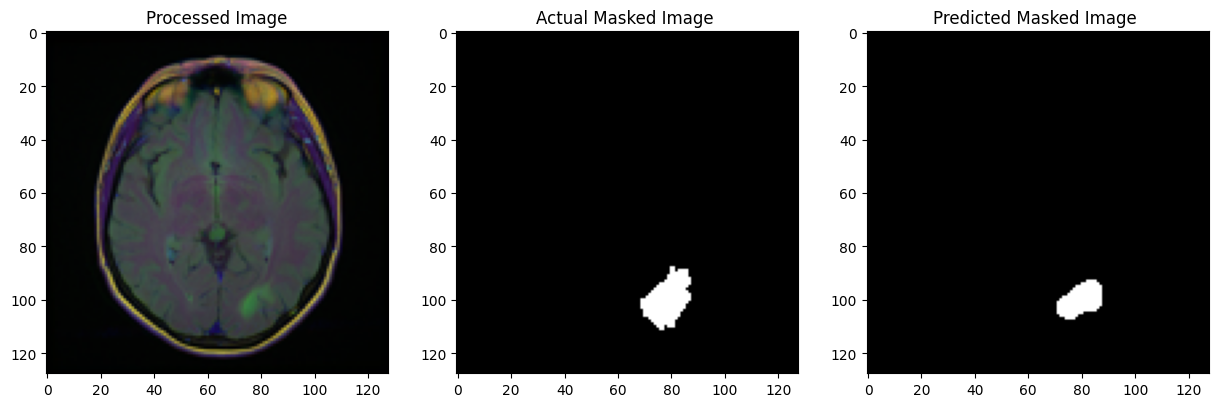

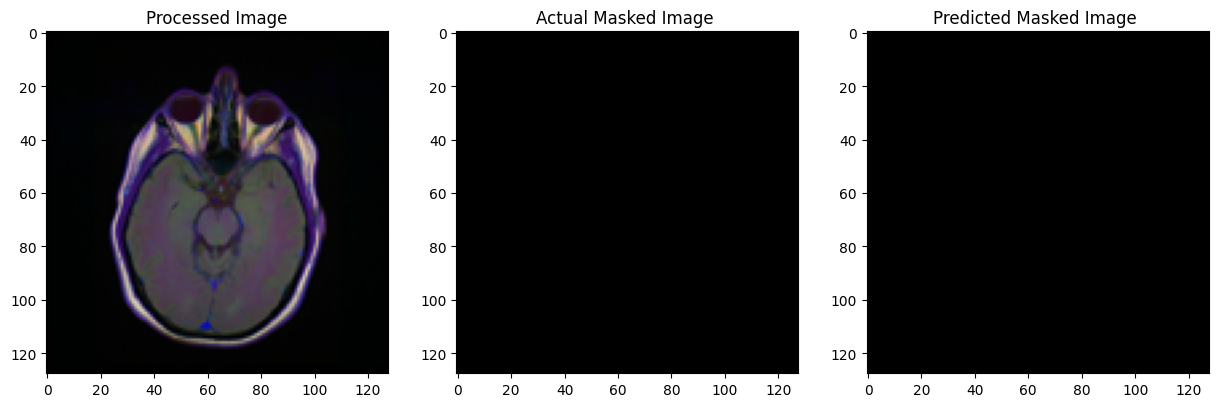

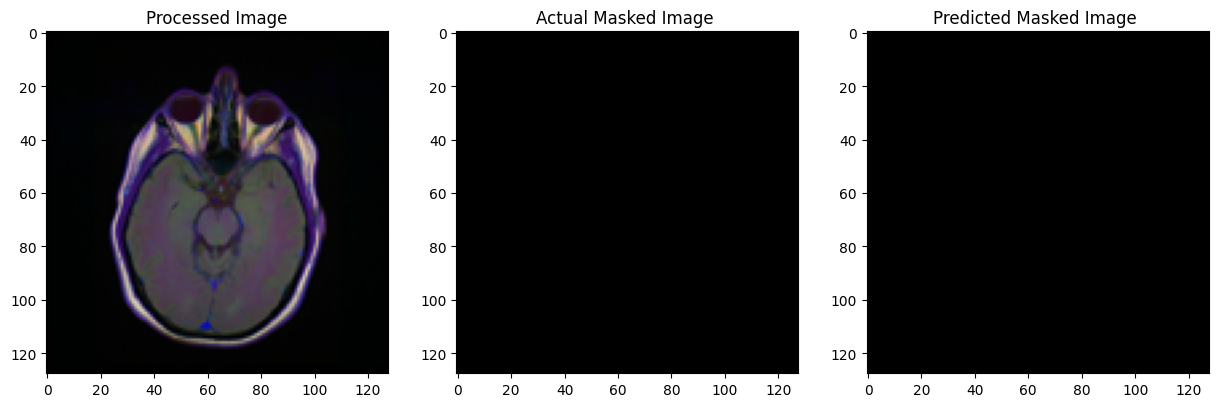

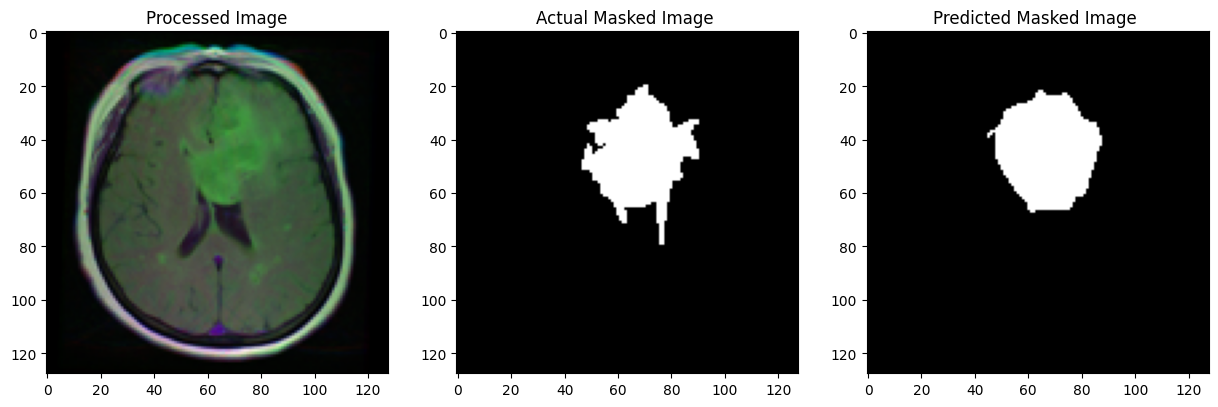

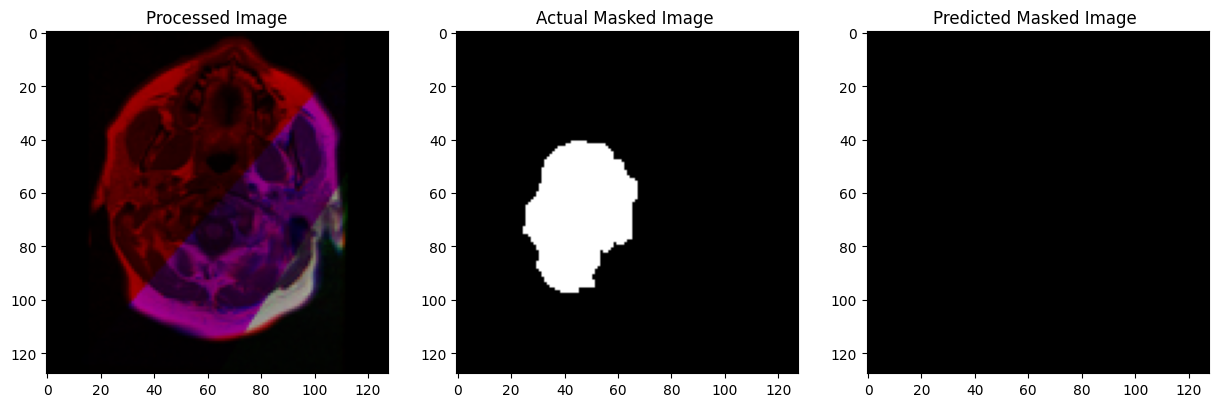

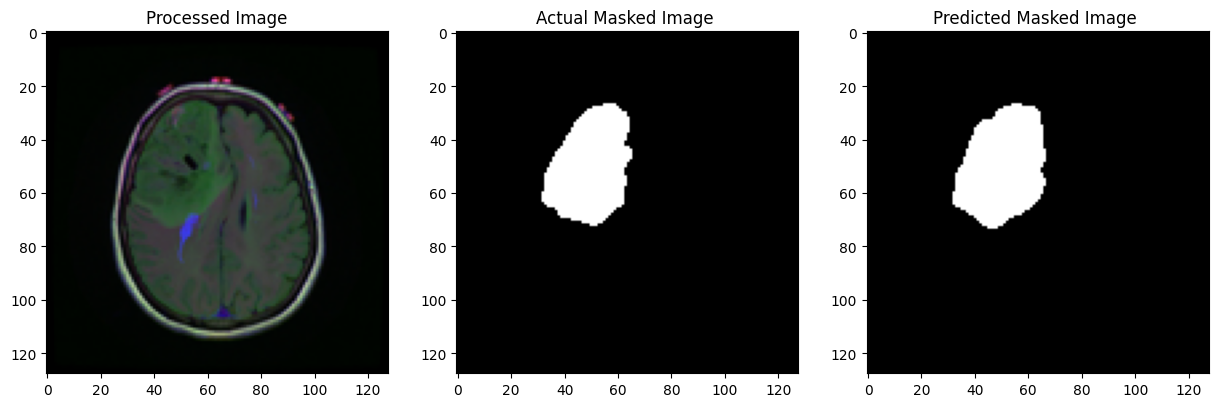

In [35]:
# Add any index to contrast the predicted mask with actual mask
index = 1
VisualizeResults(index)
index = 20
VisualizeResults(index)
index = 13
VisualizeResults(index)
index = 34
VisualizeResults(index)
index = 44
VisualizeResults(index)